<a href="https://colab.research.google.com/github/meliksahb/Design-of-Intelligent-Machines-ME536-/blob/main/CLSTR_e2738425.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Melikşah Beşir e2738425**

# **ME 536**

### Find and count characters and their elements in strings
Check if you can see the hidden ***SVD flavor*** somewhere in the requirements!

In [1]:
# only importing from following libraries are allowed. You can add more imports from them, but no new libraries here
from skimage import io
from skimage.filters import threshold_otsu as otsu
import numpy as np
from scipy.linalg import orth
from numpy.linalg import matrix_rank as rank
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering # just for demo purposes, you can import more if needed...
from scipy.spatial.distance import cdist
from sklearn.mixture import GaussianMixture
from scipy.signal import find_peaks
from scipy.ndimage import label

# also import the matrix printing function
!rm bug_numpy_utils.py 2> dump.me
!wget https://raw.githubusercontent.com/bugrakoku/bug_python_utils/main/bug_numpy_utils.py
from bug_numpy_utils import CData as CMe
from bug_numpy_utils import GenerateDataforImage as GenImMat
from bug_numpy_utils import text2mat

--2024-12-15 18:45:55--  https://raw.githubusercontent.com/bugrakoku/bug_python_utils/main/bug_numpy_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18456 (18K) [text/plain]
Saving to: ‘bug_numpy_utils.py’

bug_numpy_utils.py  100%[===================>]  18.02K  --.-KB/s    in 0.001s  

2024-12-15 18:45:55 (16.6 MB/s) - ‘bug_numpy_utils.py’ saved [18456/18456]



# Intro to Basics: Assignment has not started yet!
This is the warm up

## Generate and plot reference text
Generate data matrix from a string.

Columns of this matrix are data points, which when plotted is read as the given string.  

Using pyplot display the data points to make sure that they are readable.  

The problem is given in 2D below, play with the ```NoiseLevel``` and observe how data points mere into each other.

In [2]:
# this is a support function to see the result of clustering better

def ColorizeChars(M, Mnum = [], Title='some string', figSize = (9, 3),  aspectR = 2):
    Indicies = np.hstack((np.array([0]), np.cumsum(Mnum)))
    fig, ax = plt.subplots(figsize= figSize) # Increased figure size
    # absence of Mnum is that we do not want to colorize the plot
    if Mnum is None or Mnum is [] or len(Mnum) == 0:
        ax.plot(M[0,:],M[1,:], '*')
    else:
        for i, uLim in enumerate(Indicies):
            if i < len(Indicies)-1:
                X = M[0, uLim:Indicies[i+1]]
                Y = M[1, uLim:Indicies[i+1]]
                #plt.plot(X,Y, '*')
                ax.plot(X,Y, '*')
    ax.set_aspect(aspectR) # Set the aspect ratio to aspectR:1
    ax.set_title(Title)
    plt.show()

Shape of T1 = (3, 2087), where letters of "hello clustering" has [167, 153, 136, 136, 148, 120, 136, 141, 137, 121, 153, 90, 124, 142, 183] data points in each corresponding letter


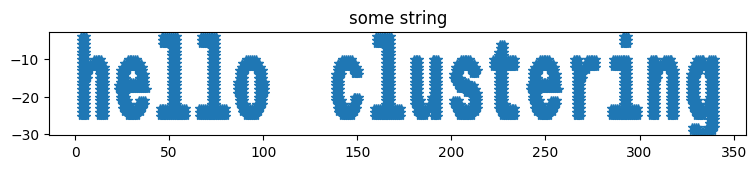

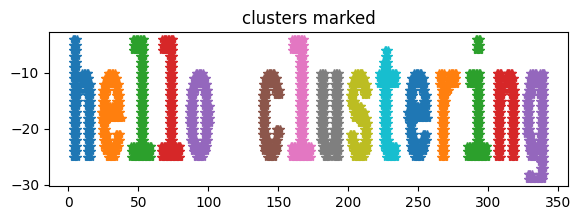

In [3]:
S1 = 'hello clustering'
T1, T1num = text2mat(S1)

# just that we get to understand ```text2mat``` function let's print the output of the function
print(f'Shape of T1 = {T1.shape}, where letters of "{S1}" has {T1num} data points in each corresponding letter')

NoiseLevel = 0.0

T1 += NoiseLevel * np.random.randn(*T1.shape)


ColorizeChars(T1) # just plot the data as a single chunk
ColorizeChars(T1, T1num, Title='clusters marked', figSize=(7,2), aspectR=4) # call this function anyway you like

### WARNING: Testing conditions is not Vanilla
Note that data matrix that will be sent might slightly be manipulated after it is generated with ```text2mat```, way beyond adding noise.  
Check out the following to give you an idea.

Note that when data matrix is shuffled, color printing makes no sense, because the columns are no more sorted, hence values returned by text2mat does not make sense.  


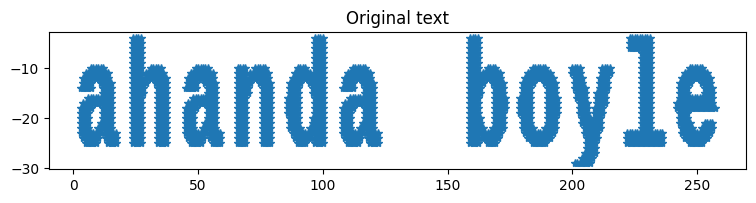

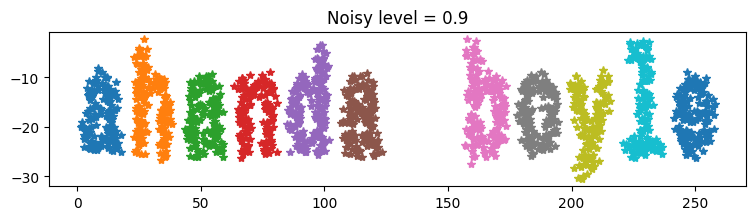

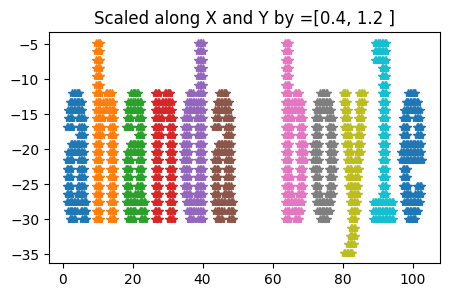

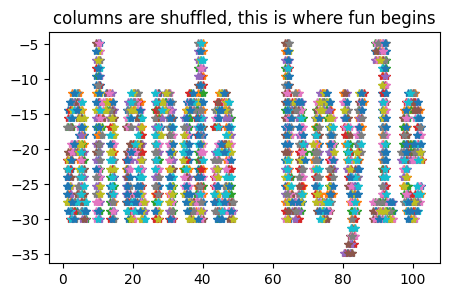

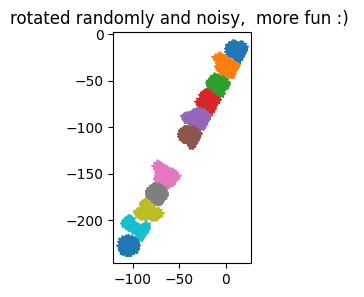

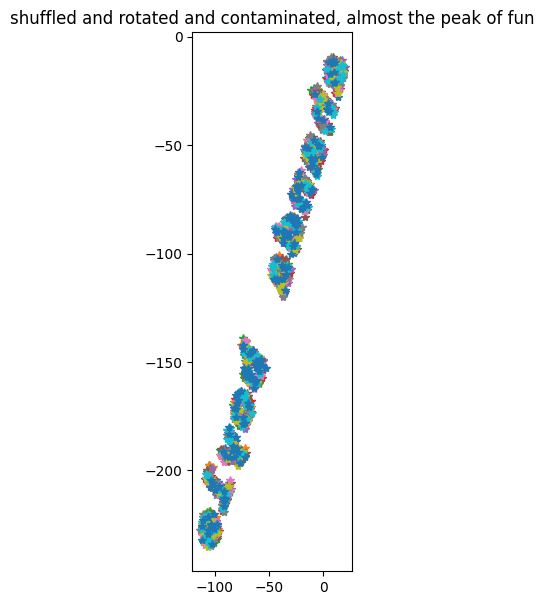

In [8]:
# CELL 1
Stest = 'ahanda boyle'
Ttest, Tnum = text2mat(Stest)
noiseLevel = 0.9

#'''
# original text
V1 = Ttest[0:2, :]
ColorizeChars(V1, Title='Original text')
#'''

#'''
# contaminated ... play with noise levels
V2 = V1 + noiseLevel * np.random.randn(*V1.shape)
ColorizeChars(V2, Tnum, Title=f'Noisy level = {noiseLevel}')
#'''

#'''
# extended or shrung along X-Y axis
V3 = np.copy(V1)
Xscale = 0.4
Yscale = 1.2
V3[0,:] *= Xscale
V3[1,:] *= Yscale
ColorizeChars(V3, Tnum, Title=f'Scaled along X and Y by =[{Xscale}, {Yscale} ]')
#'''

#'''
V4 = np.copy(V3)
V4 = V4[:, np.random.permutation(V4.shape[1])]
ColorizeChars(V4, Tnum, Title='columns are shuffled, this is where fun begins')
#'''

#'''
V5 = orth(np.random.rand(2,2)) @ V2
ColorizeChars(V5, Tnum, Title='rotated randomly and noisy,  more fun :) ', aspectR=1)
#'''


#'''
V6 = V5[:, np.random.permutation(V5.shape[1])]
ColorizeChars(V6, Tnum, Title='shuffled and rotated and contaminated, almost the peak of fun', figSize=(7,7))
v = [V1, V2, V3, V4, V5, V6]
#
#'''

# Assignment starts here
Read the following cells carefully and respond by filling in the code and text cells. Your explanations brief yet clear.

This assignment will hopefully make you better in clustering simple cases :)  
For harder cases, we will talk about artificial neural networks...

## Let's start with a show case
Note that ```text2mat``` function returns a data matrix and a list.  
Also note that the data matrix is sorted, so that the first groups of points belong to the first letter, second group to the second letter and so on.  
The list contains the number of points in each groups that correspond to the letters in the text that is sent to the function.

So your objective indeed is to recover clusters, sort them, so that when we print, it plot them using what is returned from your function, it plots properly.  

However, note that your sorting algorithm is not necessarily expected to find the order of clusters (i.e. letters), it is possible that you read the string from the end to beginning. By running the following you will see that the text might even be mirrorred. Under any circumstance, you should be able to find the alignment of the text, it does not matter wheter it is backwards or mirrorred, cluster it and return the sorted matrix along with the number of elements in each cluster, similar to what ```text2mat``` does. When we plot it using ```ColorizeChars``` it should look meaningful.

In other words, your element count list should either be similar to what text2sum returns or to the inverse of the list.  

Run the following cell for different noise levels and observe the changes.


## Clustering time:
Using any approach you like sort points in the given data matrix.
You can use hence import other sub-libraries in already imported libraries above.  
No new libraries...

Objective is to see if you can find letters indiviually.  
In other words, after we shuffle everything, objective is to check if you can

### Implemet the sorting function: i.e. ```SortPoints()```
If you would like to seperate this function into smaller other functions, write them in the support functions cell

In [9]:
# support functions goes in here so that I run them before SortPoints()
# write as many as needed
# GPT Prompt: Is there any way to Distribution-based Clustering, Connectivity-based Clustering, and Density-based Clustering working together?
# After created first code: This code create 2 cluster for 2 word. We need clusters for each letter
# I edited code and subtract a few methods.
def project_x_and_split(points, gap_threshold=10):
    """
    Project points onto the x-axis, find gaps, and split into regions.
    """
    # Project points onto the x-axis
    x_coords = points[:, 0]
    hist, bins = np.histogram(x_coords, bins=100)

    # Find peaks and gaps in the histogram
    gaps = np.diff(hist)
    split_indices = np.where(gaps < -gap_threshold)[0] + 1
    split_points = bins[split_indices]

    # Split points based on the detected gaps
    regions = []
    start = points[:, 0].min()
    for split in split_points:
        mask = (points[:, 0] >= start) & (points[:, 0] < split)
        if np.sum(mask) > 0:
            regions.append(points[mask])
        start = split
    mask = points[:, 0] >= start
    if np.sum(mask) > 0:
        regions.append(points[mask])

    return regions

def dbscan_per_region(regions, eps=3, min_samples=5):
    """
    Apply DBSCAN on each region to separate individual letters.
    """
    all_clusters = []
    for region in regions:
        if len(region) < 10:
            continue
        dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(region)
        labels = dbscan.labels_
        for label in np.unique(labels):
            if label != -1:
                all_clusters.append(region[labels == label])
    return all_clusters
def merge_close_clusters(clusters, dist_threshold=5):
    """
    Merge clusters that are close in space (for vertically disconnected parts).
    """
    merged = []
    used = set()

    for i, c1 in enumerate(clusters):
        if i in used:
            continue
        combined = c1
        for j, c2 in enumerate(clusters):
            if j in used or i == j:
                continue
            distance = np.linalg.norm(np.mean(c1, axis=0) - np.mean(c2, axis=0))
            if distance < dist_threshold:
                combined = np.vstack((combined, c2))
                used.add(j)
        merged.append(combined)
        used.add(i)
    return merged


In [10]:
def SortPoints(M, K = -1):
    '''
    Columns of M are the data points
    K is the number of clusters, if K = -1, this function is to find the number of clusters!

    returns Ms, MsNum
    Ms: the column sorted version of M, similar to what is given by text2mat before shuffle
    MsNum: element count list --> the number of points in each cluster, similar to what text2mat returns
    Note that len(MsNum) = number of letters in the original string
    '''
   # Transpose input data to (N x 2) format
    points = M.T

    # Step 1: Project and split points into regions based on x-axis gaps
    regions = project_x_and_split(points, gap_threshold=50)

    # Step 2: Apply DBSCAN within each region
    initial_clusters = dbscan_per_region(regions, eps=2, min_samples=5)

    # Step 3: Merge vertically disconnected parts of letters
    refined_clusters = merge_close_clusters(initial_clusters, dist_threshold=8)

    # Step 4: Sort clusters by horizontal position
    sorted_clusters = sorted(refined_clusters, key=lambda x: np.mean(x[:, 0]))

    # Step 5: Flatten and format the data
    Ms = []
    MsNum = []
    for cluster in sorted_clusters:
        Ms.extend(cluster)
        MsNum.append(len(cluster))

    # Convert back to required format
    Ms = np.array(Ms).T
    return Ms, MsNum

### Let's test the sorting function

If you have implemented ```SortPints``` properly, following should work.
I will only call ```SortPints``` to test your work.


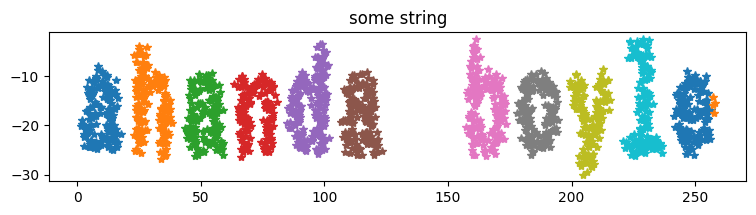

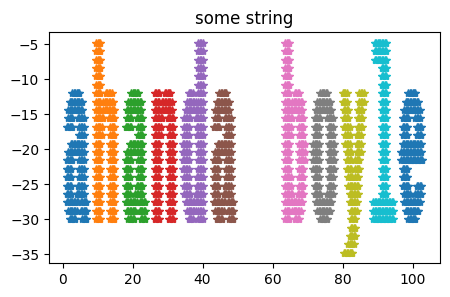

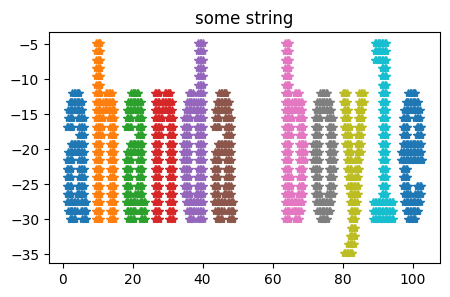

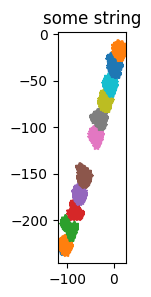

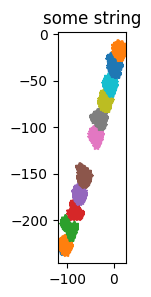

In [11]:
# let's generate test data
St = 'Test Data'
Tt, Ttsum = text2mat(St)
#in my case I will generate variations of Tt as I did above but for simplicty here I will stick with Tt

#I will run one of the following
R, Rsum = SortPoints(Tt) # case when k- number of clusters is given -
# also check for fun what happens when k is given to be something different then the correct value
for i in range(1, 6):
    R, Rsum = SortPoints(v[i], -1)
    ColorizeChars(R, Rsum)

# finally see the result



The code starts by splitting the dataset horizontally to simplify the clustering process, ensuring that each region is small enough to contain one or two letters. Within each region, DBSCAN detects the actual letter clusters. Vertically disconnected parts are then merged using a proximity check to form complete letters. Finally, clusters are sorted for proper alignment.

The points are projected onto the x-axis, and gaps in their distribution are identified using a histogram. These gaps split the dataset into smaller horizontal regions, each containing one or more letters. Within each segmented region, DBSCAN identifies dense clusters of points, corresponding to individual letters. DBSCAN works well because it can detect clusters without requiring the number of clusters in advance.

Clusters that are horizontally close and vertically overlapping are merged into single clusters. This step ensures that disconnected parts of letters like T or M are unified.

The final clusters are sorted based on their mean x-coordinate, ensuring the letters are aligned in left-to-right order.

By combining projection-based splitting, DBSCAN clustering, and merging, the code effectively separates individual letters from noisy data.